In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# from simulator import Simulation
from tqdm.auto import tqdm
import itertools
import matplotlib as mpl
from collections import OrderedDict, defaultdict

from voting_mechanism_design.agents.pairwise_badgeholder import PairwiseBadgeholder, PairwiseBadgeholderPopulation
from voting_mechanism_design.projects.project import Project, ProjectPopulation
from voting_mechanism_design.funds_distribution.pairwise_binary import PairwiseBinary
from voting_mechanism_design.sim import RoundSimulation

from voting_mechanism_design.agents.quorum_badgeholder import QuorumBadgeholder, QuorumBadgeholderPopulation
from voting_mechanism_design.funds_distribution.threshold_and_aggregate import ThresholdAndAggregate

import itertools
import numpy as np
import choix
import math

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from tqdm.auto import tqdm
from joblib import Parallel, delayed

warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [3]:
def run_single_quorum_threshold_simulation_v2(
        n_badgeholders=50,
        badgeholder_expertise_vec=None,
        badgeholder_laziness_vec=None,
        n_projects=100,
        project_impact_vec=None,
        # configuration specific to quorum+threshold voting method
        quorum=5,
        scoring_fn='mean',
        min_vote_amt=1,
        max_vote_amt=16,
        max_funding=100,
        coi_factor=0.0,
        coi_project_id=None,
        coi_badgeholder_ix=None,
        random_seed=1234
    ):
    # create voters
    voters = []
    for ii in range(n_badgeholders):
        assert badgeholder_laziness_vec[ii] >= 0

        if ii == coi_badgeholder_ix:
            coi_factor_bh = coi_factor
            coi_project_id = coi_project_id
        else:
            coi_factor_bh = 0.0
            coi_project_id = None

        v = QuorumBadgeholder(
            badgeholder_id=ii,
            total_funds=max_funding,
            min_vote=min_vote_amt,  
            max_vote=max_vote_amt,
            laziness=badgeholder_laziness_vec[ii],
            expertise=badgeholder_expertise_vec[ii],
            coi_factor=coi_factor_bh,
            coi_project_id_vec=coi_project_id,
        )
        voters.append(v)
    badgeholder_pop=QuorumBadgeholderPopulation()
    badgeholder_pop.add_badgeholders(voters)

    # add projects
    projects = []
    for ii in range(n_projects):
        p = Project(
            project_id=ii,
            true_impact=project_impact_vec[ii],  
            owner_id=None,  
        )
        projects.append(p)
    project_population = ProjectPopulation()
    project_population.add_projects(projects)

    # ##  Voting Simulation
    fund_distribution_model = ThresholdAndAggregate(
        scoring_method=scoring_fn,
        quorum=quorum,
        min_amount=0
    )
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholder_pop,
        projects=project_population,
        funding_design=fund_distribution_model,
        random_seed=random_seed
    )
    projects = project_population.get_projects()
    simulation_obj.run()

    projectid2score = simulation_obj.projectid2score

    # for easy comparison
    projectid2score = OrderedDict(projectid2score)
    ranks = np.argsort(np.asarray(list(projectid2score.values())))
    projectid2rank = {ii:ranks[ii] for ii in range(len(ranks))}
    
    return projectid2rank, ranks, simulation_obj, projectid2score

In [4]:
# a metric used for comparing the inferred ranking to the actual ranking
def min_swaps_to_sort(arr1, arr2):
    n = len(arr1)
    # Create a map of value to its index in arr1
    index_map = {value: i for i, value in enumerate(arr1)}

    visited = [False] * n
    swaps = 0

    for i in range(n):
        if visited[i] or arr1[i] == arr2[i]:
            continue

        cycle_size = 0
        x = i

        while not visited[x]:
            visited[x] = True
            x = index_map[arr2[x]]
            cycle_size += 1

        if cycle_size > 0:
            swaps += (cycle_size - 1)

    return swaps

def run_one_sim(
    n_badgeholders=50,
    n_projects=100,
    max_funding=100,
    badgeholder_expertise_vec=0.5*np.ones(50),
    badgeholder_laziness_vec=0.5*np.ones(50),
    project_impact_vec = np.linspace(0.01,0.99,100),
    quorum=5,
    scoring_fn='mean',
    min_vote_amt=1,
    max_vote_amt=16,
    coi_factor=0.0,
    badgeholder_coi_mapping=None,
    random_seed=1234
):
    # no COI
    _, ranks_no_coi, _, _ = run_single_quorum_threshold_simulation_v2(
        n_badgeholders=n_badgeholders,
        badgeholder_expertise_vec=badgeholder_expertise_vec,
        badgeholder_laziness_vec=badgeholder_laziness_vec,
        n_projects=n_projects,
        project_impact_vec=project_impact_vec,
        # configuration specific to quorum+threshold voting method
        quorum=quorum,
        scoring_fn=scoring_fn,
        min_vote_amt=min_vote_amt,
        max_vote_amt=max_vote_amt,
        max_funding=max_funding,
        random_seed=random_seed
    )

    # with COI
    coi_project_id = None
    coi_badgeholder_idx = None
    # figure out which badgeholder is doing COI, and for which project and rearrange inputs accordingly
    assert len(badgeholder_coi_mapping) == 1
    for k, v in badgeholder_coi_mapping.items():
        coi_badgeholder_idx = k
        coi_project_id = [v]

    _, ranks_coi, _, _ = run_single_quorum_threshold_simulation_v2(
        n_badgeholders=n_badgeholders,
        badgeholder_expertise_vec=badgeholder_expertise_vec,
        badgeholder_laziness_vec=badgeholder_laziness_vec,
        n_projects=n_projects,
        project_impact_vec=project_impact_vec,
        # configuration specific to quorum+threshold voting method
        quorum=quorum,
        scoring_fn=scoring_fn,
        min_vote_amt=min_vote_amt,
        max_vote_amt=max_vote_amt,
        max_funding=max_funding,
        random_seed=random_seed,
        coi_factor=coi_factor,
        coi_project_id=coi_project_id,
        coi_badgeholder_ix=coi_badgeholder_idx
    )

    # coi_project_ranking_delta = ranks_coi[coi_project_id] - ranks_no_coi[coi_project_id]
    ix_no_coi = np.where(ranks_no_coi == coi_project_id)
    ix_coi = np.where(ranks_coi == coi_project_id)
    coi_delta = ix_coi[0][0] - ix_no_coi[0][0]

    return ranks_no_coi, ranks_coi, coi_delta

def run_n_simulations(
    n_sims,
    n_badgeholders, 
    badgeholder_expertise_distribution,
    badgeholder_laziness_distribution,
    n_projects, 
    project_impact_distribution,
    quorum,
    scoring_fn,
    min_vote_amt,
    max_vote_amt,
    badgeholder_coi_mappings,
    coi_factor=0.25,
    random_seed_start=1234,
    n_jobs=-1  # Number of parallel jobs (-1 means using all processors)
):
    def run_simulation(ii):
        seed = random_seed_start + ii
        ranks_no_coi, ranks_coi, rank_delta = run_one_sim(
            n_badgeholders=n_badgeholders, 
            n_projects=n_projects, 
            badgeholder_expertise_vec=badgeholder_expertise_distribution,
            badgeholder_laziness_vec=badgeholder_laziness_distribution,
            project_impact_vec=project_impact_distribution,
            quorum=quorum,
            scoring_fn=scoring_fn,
            min_vote_amt=min_vote_amt,
            max_vote_amt=max_vote_amt,

            coi_factor=coi_factor,
            badgeholder_coi_mapping=badgeholder_coi_mappings,
            
            random_seed=seed
        )
        return ranks_no_coi, ranks_coi, rank_delta

    results = Parallel(n_jobs=n_jobs)(delayed(run_simulation)(ii) for ii in tqdm(range(n_sims), disable=True))
    # results = []
    # for ii in tqdm(range(n_sims), disable=True):
    #     results.append(run_simulation(ii))
    for k,v in badgeholder_coi_mappings.items():
        coi_badgeholder_ix = k
        coi_project_ix = v
        
    
    # compute metrics
    rr = []
    reference_ranks = np.argsort(project_impact_distribution)
    for r in results:
        # print(r[0])
        # print(reference_ranks)
        # raise ValueError("")
        min_swaps_no_coi = min_swaps_to_sort(np.asarray(r[0]), reference_ranks)
        tau_no_coi = stats.kendalltau(np.asarray(r[0]), reference_ranks).correlation
        min_swaps_coi = min_swaps_to_sort(np.asarray(r[1]), reference_ranks)
        tau_coi = stats.kendalltau(np.asarray(r[1]), reference_ranks).correlation

        rr.append({
            'min_swaps_no_coi': min_swaps_no_coi,
            'tau_no_coi': tau_no_coi,
            'min_swaps_coi': min_swaps_coi,
            'tau_coi': tau_coi,
            'coi_delta': r[2],
            # add in experiment configuration for easy dataframming
            'n_badgeholders': n_badgeholders,
            'n_projects': n_projects,
            'quorum': quorum,
            'scoring_fn': scoring_fn,
            'min_vote_amt': min_vote_amt,
            'max_vote_amt': max_vote_amt,
            'coi_factor': coi_factor,
            # assume only 1 badgeholder has COI
            'coi_project_ix': coi_project_ix,
            'coi_badgeholder_ix': coi_badgeholder_ix,
            # assume uniform expertise and laziness
            'expertise': badgeholder_expertise_distribution[0],
            'laziness': badgeholder_laziness_distribution[0],
        })
    
    return rr

In [5]:
n_sims=32
n_badgeholders=30
n_projects=100

project_impact_distribution=np.linspace(0.1,0.9,n_projects)
# badgeholder_expertise_distribution=0.75*np.ones(n_badgeholders)
# badgeholder_laziness_distribution=0.25*np.ones(n_badgeholders)
expertise_vec = [0.25, 0.5, 0.75]
laziness_vec = [0.25, 0.5, 0.75]
coi_project_idx = [0, 25, 50, 75, 99]
coi_factor_vec = [0.5, 0.75, 1.0]
experiment_cfgs = list(itertools.product(expertise_vec, laziness_vec, coi_project_idx, coi_factor_vec))

quorum=5
scoring_fn='median'
min_vote_amt=1
max_vote_amt=16
random_seed_start=1234
coi_badgeholder_ix = 0

exp2results = []
for experiment_cfg in tqdm(experiment_cfgs):
    badgeholder_expertise_distribution = experiment_cfg[0]*np.ones(n_badgeholders)
    badgeholder_laziness_distribution = experiment_cfg[1]*np.ones(n_badgeholders)
    badgeholder_coi_mappings = {coi_badgeholder_ix: experiment_cfg[2]}  # Badgeholder with COI & which project
    coi_factor = experiment_cfg[3]

    r = run_n_simulations(
        n_sims,
        n_badgeholders, 
        badgeholder_expertise_distribution,
        badgeholder_laziness_distribution,
        n_projects, 
        project_impact_distribution,
        quorum,
        scoring_fn,
        min_vote_amt,
        max_vote_amt,
        badgeholder_coi_mappings,
        coi_factor=coi_factor,
        random_seed_start=random_seed_start,
        n_jobs=-1
    )
    exp2results.extend(r)


  0%|          | 0/135 [00:00<?, ?it/s]

In [6]:
res_df = pd.DataFrame(exp2results)
# res_df['hue'] = res_df['expertise'].astype(str) + "/" + res_df['laziness'].astype(str)
res_df['hue'] = res_df.apply(lambda row: f"{row['expertise']:.2f}/{row['laziness']:.2f}", axis=1)

Text(0.5, 1.0, 'COI Factor = 1.00')

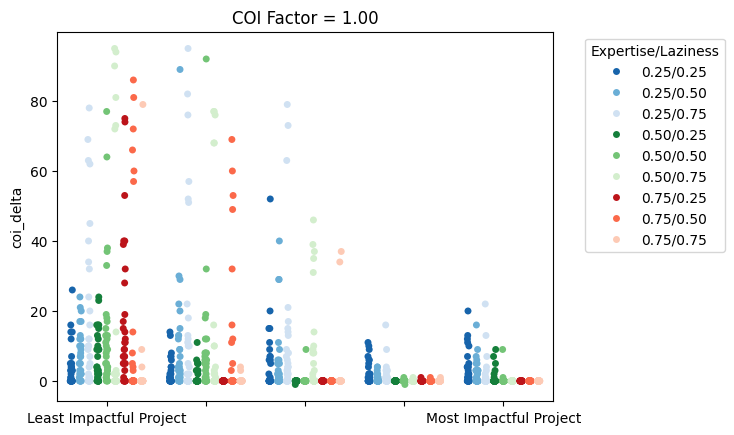

In [7]:
# setup color pallete
color_range = np.linspace(0.2, 0.8, len(laziness_vec))
colors=['Blues', 'Greens', 'Reds', 'Purples']
palette = {}
coi_factor = 1.0 # TODO: put this into a sweep
for jj, m in enumerate(expertise_vec):
    color = mpl.colormaps[colors[jj]]
    for ii, l in enumerate(laziness_vec):
        key='%0.02f/%0.02f' % (m, l)
        palette[key] = color(color_range[len(laziness_vec)-ii-1])

ax = sns.stripplot(
    data=res_df[res_df['coi_factor']==coi_factor], 
    x='coi_project_ix', 
    y='coi_delta', 
    hue='hue', 
    dodge=True,
    palette=palette,
)
ax.set_xticklabels(['Least Impactful Project', '', '', '', 'Most Impactful Project'])
ax.set_xlabel('')
ax.legend(title='Expertise/Laziness', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('COI Factor = %0.2f' % coi_factor)